<a href="https://colab.research.google.com/github/EvgSkv/virtual_people_examples/blob/main/notebooks/Combining_Dirac_Mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining Dirac Mixture with Device Population via Independence Assumption

[evgskv@](https://github.com/evgskv) (Google)

This CoLab illustrates how to build a cross-device ADF out of given per-device marginal ADFs and census information about device usage, under the assumption of independence of device activity within each device usage pool. 

For each device usage pool ADF is constructed out of marginal ADFs and activities corresponding to devices excluded from this pool are set to 0.
This ADF for a given device usage pool will have the number of deltas equal to the product of the numnber of deltas of the involved ADFs. These deltas are built by setting appropriate coordinates to each pair of deltas from original ADFs times activity adjustment, required for scaling activities given newly added population inactive on the devices. Alphas are products of the original alphas and fraction of this device usage pool.

## Illustration of Mixture building in Python

In [1]:
import json

def Delta2D(a, b):
  return {"coordinates": [a, b]}

# Dirac mixtures are Python dicts here, but they comply with ADF schema as
# defined at:
# https://github.com/world-federation-of-advertisers/virtual-people-training/blob/main/src/main/proto/wfa/virtual_people/training/activity_density_function.proto

# Defining mock input data.
# An ADF for mobile and desktop, each working with login and logout ids.
# WARNING: Having LOGIN ids modelled separately on mobile and desktop might be
# leading to _cookie shredding_.
# Cookie shredding is behavior of the model  when a given user id gets assigned
# to more then 1 virtual person for artificial reasons.
# In this scenario a login ID used on mobile and desktop could get assigned
# to different IDs if marginal ADFs differ. Careful approach is needed for
# cookie shredding to prevent if from distorting model results.

# Mobile ADF.
mobile_adf = {
    "name": "mobile",
    "identifier_type_names": ["login", "logout"],
    "dirac_mixture": {"alphas": [0.5,
                                 0.5],
                      "deltas": [Delta2D(0.9, 0.5),
                                 Delta2D(1.1, 1.4)]}
}

# Desktop ADF.
desktop_adf = {
    "name": "desktop",
    "identifier_type_names": ["login", "logout"],
    "dirac_mixture": {"alphas": [0.3,
                                 0.4,
                                 0.3],
                      "deltas": [Delta2D(0.7, 0.8),
                                 Delta2D(1.0, 1.0),
                                 Delta2D(1.1, 0.5)]}
}

# Overlap information.
internet_fraction = [{"mobile": True, "desktop": True, "fraction": 0.5},
                     {"mobile": False, "desktop": True, "fraction": 0.2},
                     {"mobile": True, "desktop": False, "fraction": 0.3}]

# Utility function to extract overlap size from internet_fraction.
def GetInternetFraction(mobile, desktop, internet_fractions_list):
  for row in internet_fractions_list:
    if row["mobile"] == mobile and row["desktop"] == desktop:
      return row["fraction"]
  assert False, "Could not retrieve internet fraction."

# Combining mobile and desktop ADFs with overlap info to produce a joint
# ADF that acts like the ADFs on marginals and produces the required overlaps.
# Combining is done under the conditional independence (or equivalently maximal
# entropy) assumption.
def JoinedMixture(mobile_adf, desktop_adf, internet_fraction):
  result_alphas = []
  result_deltas = []

  # When people who don't possess a device are added the activity of people
  # who use device needs to be adjusted.
  mobile_population = (
      GetInternetFraction(True, True, internet_fraction) +
      GetInternetFraction(True, False, internet_fraction))
  desktop_population = (
      GetInternetFraction(True, True, internet_fraction) +
      GetInternetFraction(False, True, internet_fraction))
        
  mobile_activity_adjustment = 1.0 / mobile_population
  desktop_activity_adjustment = 1.0 / desktop_population
  def Adjust(activities_list, adjustment):
    return [activity * adjustment for activity in activities_list]
  # Both-devices population portion.
  f = GetInternetFraction(True, True, internet_fraction)
  for mobile_alpha, mobile_delta in zip(mobile_adf["dirac_mixture"]["alphas"],
                                        mobile_adf["dirac_mixture"]["deltas"]):
    for desktop_alpha, desktop_delta in zip(desktop_adf["dirac_mixture"]["alphas"],
                                            desktop_adf["dirac_mixture"]["deltas"]):
      alpha = mobile_alpha * desktop_alpha * f
      # Concatenate activities.
      activities = (
          Adjust(mobile_delta["coordinates"], mobile_activity_adjustment) +
          Adjust(desktop_delta["coordinates"], desktop_activity_adjustment))
        
      delta = {"coordinates": activities}
      result_alphas.append(alpha)
      result_deltas.append(delta)

  # Desktop-only portion.
  f = GetInternetFraction(False, True, internet_fraction)
  for desktop_alpha, desktop_delta in zip(desktop_adf["dirac_mixture"]["alphas"],
                                          desktop_adf["dirac_mixture"]["deltas"]):
    alpha = desktop_alpha * f
    # Concatenate activities.
    activities = (
        [0, 0] +
        Adjust(desktop_delta["coordinates"], desktop_activity_adjustment))
    delta = {"coordinates": activities}
    result_alphas.append(alpha)
    result_deltas.append(delta)  

  # Mobile-only portion.
  f = GetInternetFraction(True, False, internet_fraction)
  for mobile_alpha, mobile_delta in zip(mobile_adf["dirac_mixture"]["alphas"],
                                          mobile_adf["dirac_mixture"]["deltas"]):
    alpha = mobile_alpha * f
    # Concatenate activities.
    activities = (
        Adjust(mobile_delta["coordinates"], mobile_activity_adjustment) +
        [0, 0])
    delta = {"coordinates": activities}
    result_alphas.append(alpha)
    result_deltas.append(delta)  

  result = {
      "name": "cross-device",
      "identifier_type_name": [
          "mobile-login", "mobile-logout", "desktop-login", "desktop-logout"],
      "dirac_mixture": {
          "alphas": result_alphas,
          "deltas": result_deltas
      }
  }

  return result

joined_adf = JoinedMixture(mobile_adf, desktop_adf, internet_fraction)

print(json.dumps(joined_adf, indent="  "))
    


{
  "name": "cross-device",
  "identifier_type_name": [
    "mobile-login",
    "mobile-logout",
    "desktop-login",
    "desktop-logout"
  ],
  "dirac_mixture": {
    "alphas": [
      0.075,
      0.1,
      0.075,
      0.075,
      0.1,
      0.075,
      0.06,
      0.08000000000000002,
      0.06,
      0.15,
      0.15
    ],
    "deltas": [
      {
        "coordinates": [
          1.125,
          0.625,
          1.0,
          1.142857142857143
        ]
      },
      {
        "coordinates": [
          1.125,
          0.625,
          1.4285714285714286,
          1.4285714285714286
        ]
      },
      {
        "coordinates": [
          1.125,
          0.625,
          1.5714285714285716,
          0.7142857142857143
        ]
      },
      {
        "coordinates": [
          1.375,
          1.75,
          1.0,
          1.142857142857143
        ]
      },
      {
        "coordinates": [
          1.375,
          1.75,
          1.4285714285714286,
     

Mobile limit: [0.8] expected: 0.8
Desktop limit: [0.7] expected: 0.7
Mobile deltas:
 [[0.9 0.5]
 [1.1 1.4]]
Mobile alphas: [0.5, 0.5]
Desktop deltas:
 [[0.7 0.8]
 [1.  1. ]
 [1.1 0.5]]
Desktop alphas: [0.3, 0.4, 0.3]
Joint deltas:
 [[1.125      0.625      1.         1.14285714]
 [1.125      0.625      1.42857143 1.42857143]
 [1.125      0.625      1.57142857 0.71428571]
 [1.375      1.75       1.         1.14285714]
 [1.375      1.75       1.42857143 1.42857143]
 [1.375      1.75       1.57142857 0.71428571]
 [0.         0.         1.         1.14285714]
 [0.         0.         1.42857143 1.42857143]
 [0.         0.         1.57142857 0.71428571]
 [1.125      0.625      0.         0.        ]
 [1.375      1.75       0.         0.        ]]
Joint alphas:
 [0.075, 0.1, 0.075, 0.075, 0.1, 0.075, 0.06, 0.08000000000000002, 0.06, 0.15, 0.15]
Mobile marginal kappas:
 [[1.  ]
 [0.95]]
Desktop marginal kappas:
 [[0.94]
 [0.79]]
Joint kappas:
 [[1.  ]
 [0.95]
 [0.94]
 [0.79]]


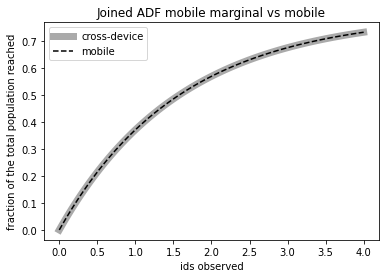

In [2]:
import numpy
from matplotlib import pyplot

# Visual testing of the JoinedMixture function.

# A class to apply DiracMixture.
class DiracMixture(object):
  def __init__(self, adf):
    self.alphas = adf["dirac_mixture"]["alphas"]
    self.ds = numpy.array(
        [delta["coordinates"] for delta in adf["dirac_mixture"]["deltas"]])
  
  def __call__(self, signal):
    return numpy.hstack(self.alphas).dot(1 - numpy.exp(- self.ds.dot(signal.T)))

  def Kappa(self):
    return self.ds.T.dot(numpy.hstack(self.alphas)[:, None])

# Initializing Dirac Mixtures.
desktop_dm = DiracMixture(desktop_adf)
mobile_dm = DiracMixture(mobile_adf)

# Building a joint mixture.
joined_dm = DiracMixture(joined_adf)

# Extracting by-device populations.
mobile_population = (
    GetInternetFraction(True, False, internet_fraction) +
    GetInternetFraction(True, True, internet_fraction))
desktop_population = (
    GetInternetFraction(False, True, internet_fraction) +
    GetInternetFraction(True, True, internet_fraction))

# Verifying that limits are respected.
print("Mobile limit:", joined_dm(numpy.array([[100, 0, 0, 0]])),
      "expected:", mobile_population)
print("Desktop limit:", joined_dm(numpy.array([[0, 0, 100, 0]])),
      "expected:", desktop_population)

print("Mobile deltas:\n", mobile_dm.ds)
print("Mobile alphas:", mobile_dm.alphas)

print("Desktop deltas:\n", desktop_dm.ds)
print("Desktop alphas:", desktop_dm.alphas)

print("Joint deltas:\n", joined_dm.ds)
print("Joint alphas:\n", joined_dm.alphas)

print("Mobile marginal kappas:\n", mobile_dm.Kappa())
print("Desktop marginal kappas:\n", desktop_dm.Kappa())


print("Joint kappas:\n", joined_dm.Kappa())
# Verifying that marginal mobile reach curve is respected.
# Desktop and per-space curves should also match.
max_x = 2

xs = numpy.linspace(0, max_x, 100)
mobile_campaigns_in_mobile = numpy.vstack([xs,
                                           xs * 0]).T


mobile_campaigns_in_joined = numpy.vstack([xs,
                                           xs * 0,
                                           numpy.zeros(100),
                                           numpy.zeros(100)]).T

# Getting a marginal curve from the joined mixture.
mobile_reach_in_joined = joined_dm(mobile_campaigns_in_joined)
# Getting a mobile curve. Adjusting to the global population size.
mobile_reach_in_mobile = mobile_dm(
    mobile_campaigns_in_mobile / mobile_population) * mobile_population

# Plotting the chart.
pyplot.title("Joined ADF mobile marginal vs mobile")
pyplot.plot(2 * xs, mobile_reach_in_joined,
            label='cross-device', color='#aaa', linewidth=7)
pyplot.plot(2 * xs, mobile_reach_in_mobile,
            label='mobile', color='black', linestyle='--')
pyplot.xlabel('ids observed')
pyplot.ylabel('fraction of the total population reached')
pyplot.legend(loc='best')
None

## Illustration of joined Mixture building in Logica

Code below is equivalent to Python, written in [Logica](https://github.com/evgskv/logica) language for doublechecking correctness.

Safe to disregard if you prefer Python.

In [3]:
!pip install logica

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 329 kB/s 


In [4]:
from logica import colab_logica

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at MobileAdf_sql variable.
SELECT
  STRUCT("Mobile" AS name, ARRAY["login", "logout"] AS identifier_type_names, STRUCT(ARRAY[0.5, 0.5] AS alphas, ARRAY[STRUCT(ARRAY[0.9, 0.5] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas) AS dirac_mixture) AS logica_value;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at MobileMixture_sql variable.
SELECT
  STRUCT(ARRAY[0.5, 0.5] AS alphas, ARRAY[STRUCT(ARRAY[0.9, 0.5] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).deltas[OFFSET(x_5)].coordinates AS activities,
  STRUCT(ARRAY[0.5, 0.5] AS alphas, ARRAY[STRUCT(ARRAY[0.9, 0.5] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).alphas[OFFSET(x_5)] AS alpha
FROM
  UNNEST(GENERATE_ARRAY(0, ARRAY_LENGTH(STRUCT(ARRAY[0.5, 0.5] AS alphas, ARRAY[STRUCT(ARRAY[0.9, 0.5] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).alphas) - 1)) as x_5;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at DesktopMixture_sql variable.
SELECT
  STRUCT(ARRAY[0.3, 0.4, 0.3] AS alphas, ARRAY[STRUCT(ARRAY[0.7, 0.8] AS coordinates), STRUCT(ARRAY[1.0, 1.0] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).deltas[OFFSET(x_5)].coordinates AS activities,
  STRUCT(ARRAY[0.3, 0.4, 0.3] AS alphas, ARRAY[STRUCT(ARRAY[0.7, 0.8] AS coordinates), STRUCT(ARRAY[1.0, 1.0] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).alphas[OFFSET(x_5)] AS alpha
FROM
  UNNEST(GENERATE_ARRAY(0, ARRAY_LENGTH(STRUCT(ARRAY[0.3, 0.4, 0.3] AS alphas, ARRAY[STRUCT(ARRAY[0.7, 0.8] AS coordinates), STRUCT(ARRAY[1.0, 1.0] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).alphas) - 1)) as x_5;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at JoinedMixture_sql variable.
WITH t_9_InternetFraction AS (SELECT * FROM (
  
    SELECT
      true AS mobile,
      true AS desktop,
      0.5 AS fraction
   UNION ALL
  
    SELECT
      false AS mobile,
      true AS desktop,
      0.2 AS fraction
   UNION ALL
  
    SELECT
      true AS mobile,
      false AS desktop,
      0.3 AS fraction
  
) AS UNUSED_TABLE_NAME  ),
t_10_DevicePopulation AS (SELECT
  SUM(((CASE WHEN t_11_InternetFraction.mobile THEN 1.0 ELSE 0.0 END) * (t_11_InternetFraction.fraction))) AS mobile,
  SUM(((CASE WHEN t_11_InternetFraction.desktop THEN 1.0 ELSE 0.0 END) * (t_11_InternetFraction.fraction))) AS desktop
FROM
  t_9_InternetFraction AS t_11_InternetFraction)
SELECT * FROM (
  
    SELECT
      "cross-device" AS delta_type,
      ARRAY_CONCAT((SELECT
      ARRAY_AGG(((STRUCT(ARRAY[0.5, 0.5] AS alphas, ARRAY[STRUCT(ARRAY[0.9, 0.5] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).deltas[OFFSET(x_9)].coordi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at FinalAlphaSum_sql variable.
WITH t_10_InternetFraction AS (SELECT * FROM (
  
    SELECT
      true AS mobile,
      true AS desktop,
      0.5 AS fraction
   UNION ALL
  
    SELECT
      false AS mobile,
      true AS desktop,
      0.2 AS fraction
   UNION ALL
  
    SELECT
      true AS mobile,
      false AS desktop,
      0.3 AS fraction
  
) AS UNUSED_TABLE_NAME  ),
t_11_DevicePopulation AS (SELECT
  SUM(((CASE WHEN t_12_InternetFraction.mobile THEN 1.0 ELSE 0.0 END) * (t_12_InternetFraction.fraction))) AS mobile,
  SUM(((CASE WHEN t_12_InternetFraction.desktop THEN 1.0 ELSE 0.0 END) * (t_12_InternetFraction.fraction))) AS desktop
FROM
  t_10_InternetFraction AS t_12_InternetFraction),
t_0_JoinedMixture AS (SELECT * FROM (
  
    SELECT
      "cross-device" AS delta_type,
      ARRAY_CONCAT((SELECT
      ARRAY_AGG(((STRUCT(ARRAY[0.5, 0.5] AS alphas, ARRAY[STRUCT(ARRAY[0.9, 0.5] AS coordinates), STRUCT(ARRAY[1.1, 0.5] AS coordinates)] AS deltas).d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

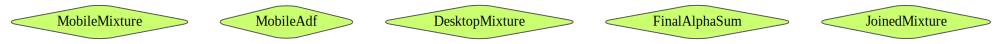

Running predicate: MobileMixture (0 seconds)
Running predicate: MobileAdf (1 seconds)
Running predicate: DesktopMixture (0 seconds)
Running predicate: FinalAlphaSum (1 seconds)
Running predicate: JoinedMixture (1 seconds)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at MobileAdf variable.


,logica_value
0,"{'name': 'Mobile', 'identifier_type_names': ['..."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at MobileMixture variable.


,activities,alpha
0,"[0.9, 0.5]",0.5
1,"[1.1, 0.5]",0.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at DesktopMixture variable.


,activities,alpha
0,"[0.7, 0.8]",0.3
1,"[1.0, 1.0]",0.4
2,"[1.1, 0.5]",0.3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at JoinedMixture variable.


,delta_type,activities,alpha
0,cross-device,"[1.125, 0.625, 1.0, 1.142857142857143]",0.075
1,cross-device,"[1.375, 0.625, 1.0, 1.142857142857143]",0.075
2,cross-device,"[1.125, 0.625, 1.4285714285714286, 1.428571428...",0.100
3,cross-device,"[1.375, 0.625, 1.4285714285714286, 1.428571428...",0.100
4,cross-device,"[1.125, 0.625, 1.5714285714285716, 0.714285714...",0.075
5,cross-device,"[1.375, 0.625, 1.5714285714285716, 0.714285714...",0.075
6,desktop-only,"[0.0, 0.0, 1.0, 1.142857142857143]",0.060
7,desktop-only,"[0.0, 0.0, 1.4285714285714286, 1.4285714285714...",0.080
8,desktop-only,"[0.0, 0.0, 1.5714285714285716, 0.7142857142857...",0.060
9,mobile-only,"[1.125, 0.625, 0.0, 0.0]",0.150


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at FinalAlphaSum variable.


,logica_value
0,1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
%%logica MobileAdf, MobileMixture, DesktopMixture, JoinedMixture, FinalAlphaSum
#MobileAdf, MobileDeltaCount, InternetFraction

Delta2D(x, y) = {coordinates: [x, y]};

MobileAdf() = {
    name: "Mobile",
    identifier_type_names: ["login", "logout"],
    dirac_mixture: {alphas: [0.5, 0.5],
                    deltas: [Delta2D(0.9, 0.5),
                             Delta2D(1.1, 0.5)]}
};
MobileDeltaCount() = Size(MobileAdf().dirac_mixture.alphas);

MobileMixture(activities:, alpha:) :-
  i in Range(MobileDeltaCount()),
  alpha == Element(MobileAdf().dirac_mixture.alphas, i),
  activities == Element(MobileAdf().dirac_mixture.deltas, i).coordinates;


DesktopAdf() = {
    name: "Desktop",
    identifier_type_name: ["login", "logout"],
    dirac_mixture: {alphas: [0.3, 0.4, 0.3],
                    deltas: [Delta2D(0.7, 0.8),
                             Delta2D(1.0, 1.0),
                             Delta2D(1.1, 0.5)]}
};
DesktopDeltaCount() = Size(DesktopAdf().dirac_mixture.alphas);
DesktopMixture(activities:, alpha:) :-
  i in Range(DesktopDeltaCount()),
  alpha == Element(DesktopAdf().dirac_mixture.alphas, i),
  activities == Element(DesktopAdf().dirac_mixture.deltas, i).coordinates;


InternetFraction(mobile: true, desktop: true, fraction: 0.5);
InternetFraction(mobile: false, desktop: true, fraction: 0.2);
InternetFraction(mobile: true, desktop: false, fraction: 0.3);

DevicePopulation(mobile? += has_mobile * fraction,
                 desktop? += has_desktop * fraction) distinct :-
  InternetFraction(mobile:, desktop:, fraction:),
  has_mobile == (if mobile then 1.0 else 0.0),
  has_desktop == (if desktop then 1.0 else 0.0);

ElementWiseMultiply(v, k) = v_times_k :-
  v_times_k Array= (
      i -> a * k :-
      i in RangeOf(v),
      a == Element(v, i)
  );

MobileActivityAdjustment(activity) = adjusted_activity :-
  adjustment == 1 / mobile,
  DevicePopulation(mobile:),
  adjusted_activity == ElementWiseMultiply(activity, adjustment);

DesktopActivityAdjustment(activity) = adjusted_activity :-
  adjustment == 1 / desktop,
  DevicePopulation(desktop:),
  adjusted_activity == ElementWiseMultiply(activity, adjustment);


JoinedMixture(
    delta_type: "cross-device",
    activities:,
    alpha:) :-
  mobile_adf == MobileAdf(),
  desktop_adf == DesktopAdf(),
  InternetFraction(mobile: true, desktop: true, fraction:),
  mobile_delta_index in RangeOf(mobile_adf.dirac_mixture.alphas),
  desktop_delta_index in RangeOf(desktop_adf.dirac_mixture.alphas), 
  mobile_delta == Element(mobile_adf.dirac_mixture.deltas, mobile_delta_index),
  desktop_delta == Element(desktop_adf.dirac_mixture.deltas, desktop_delta_index),
  activities == ArrayConcat(
      MobileActivityAdjustment(mobile_delta.coordinates),
      DesktopActivityAdjustment(desktop_delta.coordinates)),
  mobile_alpha == Element(mobile_adf.dirac_mixture.alphas, mobile_delta_index),
  desktop_alpha == Element(desktop_adf.dirac_mixture.alphas, desktop_delta_index),
  alpha == mobile_alpha * desktop_alpha * fraction;

JoinedMixture(
    delta_type: "desktop-only",
    activities:,
    alpha:) :-
  desktop_adf == DesktopAdf(),
  InternetFraction(mobile: false, desktop: true, fraction:),
  desktop_delta_index in RangeOf(desktop_adf.dirac_mixture.alphas), 
  desktop_delta == Element(desktop_adf.dirac_mixture.deltas, desktop_delta_index),
  activities == ArrayConcat(
      [0.0, 0.0],
      DesktopActivityAdjustment(desktop_delta.coordinates)),
  desktop_alpha == Element(desktop_adf.dirac_mixture.alphas, desktop_delta_index),
  alpha == desktop_alpha * fraction;
  
JoinedMixture(
    delta_type: "mobile-only",
    activities:,
    alpha:) :-
  mobile_adf == MobileAdf(),
  InternetFraction(mobile: true, desktop: false, fraction:),
  mobile_delta_index in RangeOf(mobile_adf.dirac_mixture.alphas), 
  mobile_delta == Element(mobile_adf.dirac_mixture.deltas, mobile_delta_index),
  activities == ArrayConcat(
      MobileActivityAdjustment(mobile_delta.coordinates),
      [0.0, 0.0]),
  mobile_alpha == Element(mobile_adf.dirac_mixture.alphas, mobile_delta_index),
  alpha == mobile_alpha * fraction;

FinalAlphaSum() += alpha :- JoinedMixture(alpha:);

In [6]:
print(json.dumps(MobileAdf.logica_value[0], indent="  "))

{
  "name": "Mobile",
  "identifier_type_names": [
    "login",
    "logout"
  ],
  "dirac_mixture": {
    "alphas": [
      0.5,
      0.5
    ],
    "deltas": [
      {
        "coordinates": [
          0.9,
          0.5
        ]
      },
      {
        "coordinates": [
          1.1,
          0.5
        ]
      }
    ]
  }
}
